# Lab 10.5.2 VGG for cifar10

**Jonathan Choi 2021**

**[Deep Learning By Torch] End to End study scripts of Deep Learning by implementing code practice with Pytorch.**

If you have an any issue, please PR below.

[[Deep Learning By Torch] - Github @JonyChoi](https://github.com/jonychoi/Deep-Learning-By-Torch)

Here, we are going to apply our VGG network to cifar10 datasets.

Reference from

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## Imports

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1)

if device == 'cuda':
    torch.cuda.manual_seed_all(1)

## What about data?

We will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![](https://pytorch.org/tutorials/_images/cifar10.png)

## Training an image classifier
We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

## Load and normalize CIFAR10
Using torchvision, it’s extremely easy to load CIFAR10.

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

### Take a Moment!

**CLASS** ```torchvision.transforms.Normalize(mean, std, inplace=False)```

Normalize a tensor image with mean and standard deviation. This transform does not support PIL Image. Given mean: ```(mean[1],...,mean[n])``` and std: ```(std[1],..,std[n])``` for n channels, this transform will normalize each channel of the input ```torch.*Tensor``` i.e., ```output[channel] = (input[channel] - mean[channel]) / std[channel]```

**NOTE**

This transform acts out of place, i.e., it does not mutate the input tensor.

**Parameters**

> - mean (sequence) – Sequence of means for each channel.

> - std (sequence) – Sequence of standard deviations for each channel.

> - inplace (bool,optional) – Bool to make this operation in-place.

Examples using ```Normalize```:

[Tensor transforms and JIT](https://pytorch.org/vision/stable/auto_examples/plot_scripted_tensor_transforms.html#sphx-glr-auto-examples-plot-scripted-tensor-transforms-py)

### **forward(tensor: torch.Tensor) → torch.Tensor**

Parameters

- tensor (Tensor) – Tensor image to be normalized.

Returns

- Normalized Tensor image.

Return type

- Tensor

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

)

trainset = datasets.CIFAR10(root = './cifar10', train = True, download = True, transform = transform)

testset = datasets.CIFAR10(root = './cifar10', train=False, download = True, transform = transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Take a Moment!

**CLASS** ```torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None, generator=None, *, prefetch_factor=2, persistent_workers=False)```

Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.

The ```DataLoader``` supports both map-style and iterable-style datasets with single- or multi-process loading, customizing loading order and optional automatic batching (collation) and memory pinning.

See ```torch.utils.data``` documentation page for more details.

**Parameters**

- **dataset** (Dataset) – dataset from which to load the data.

- **batch_size** (int, optional) – how many samples per batch to load (default: 1).

- **shuffle** (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).

- **sampler** (Sampler or Iterable, optional) – defines the strategy to draw samples from the dataset. Can be any Iterable with __len__ implemented. If specified, shuffle must not be specified.

- **batch_sampler** (Sampler or Iterable, optional) – like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.

- **num_workers** (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)

- **collate_fn** (callable, optional) – merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style dataset.

- **pin_memory** (bool, optional) – If True, the data loader will copy Tensors into CUDA pinned memory before returning them. If your data elements are a custom type, or your collate_fn returns a batch that is a custom type, see the example below.

- **drop_last** (bool, optional) – set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

- **timeout** (numeric, optional) – if positive, the timeout value for collecting a batch from workers. Should always be non-negative. (default: 0)

- **worker_init_fn** (callable, optional) – If not None, this will be called on each worker subprocess with the worker id (an int in [0, num_workers - 1]) as input, after seeding and before data loading. (default: None)

- **generator** (torch.Generator, optional) – If not None, this RNG will be used by RandomSampler to generate random indexes and multiprocessing to generate base_seed for workers. (default: None)

- **prefetch_factor** (int, optional, keyword-only arg) – Number of samples loaded in advance by each worker. 2 means there will be a total of 2 * num_workers samples prefetched across all workers. (default: 2)

- **persistent_workers** (bool, optional) – If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the workers Dataset instances alive. (default: False)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = trainset, shuffle = True, batch_size = 512, drop_last = False, num_workers = 1)
test_loader = torch.utils.data.DataLoader(dataset = testset, shuffle = True, batch_size = 4 , drop_last = False, num_workers = 1)

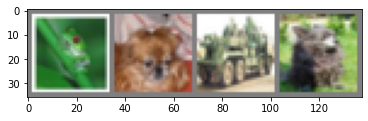

 frog   dog truck   dog


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define Loss Tracker

In [108]:
import visdom

vis = visdom.Visdom()
vis.close(env = "main")

Setting up a new session...


''

In [109]:
def loss_tracker(loss_plot, loss_value, num):
    vis.line(X = num, Y = loss_value, win = loss_plot, update = 'append')

In [110]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

## Define a Convolutional Neural Network

We are going to use VGG model, that we defined before section.

In [13]:
import torchvision.models.vgg as vgg

In [17]:
def make_layers(cfg, batch_norm = False):
    layers = []
    in_channels = 3

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = v
    
    return nn.Sequential(*layers)

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
}

conv = make_layers(cfg['A'], batch_norm=True)

model = vgg.VGG(conv, num_classes = 10, init_weights = True).to(device)

## Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [18]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.001, momentum = 0.9)

## Train the network

In [114]:
total_batch = len(train_loader)

training_epochs = 100

for epoch in range(training_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 7 == 6:    # print every 7 mini-batches

            running_loss = running_loss / 7

            loss_tracker(loss_plt, torch.Tensor([running_loss]), torch.Tensor([i + epoch*total_batch ]))
            print('Epoch: {} / 20, MiniBatch: {} / {} Cost: {:.6f}'.format(epoch + 1, i + 1, total_batch, running_loss))
            running_loss = 0.0

print('Finished Training')

Epoch: 1 / 20, MiniBatch: 7 / 98 Cost: 2.538052
Epoch: 1 / 20, MiniBatch: 14 / 98 Cost: 2.382969
Epoch: 1 / 20, MiniBatch: 21 / 98 Cost: 2.276173
Epoch: 1 / 20, MiniBatch: 28 / 98 Cost: 2.150281
Epoch: 1 / 20, MiniBatch: 35 / 98 Cost: 2.073248
Epoch: 1 / 20, MiniBatch: 42 / 98 Cost: 1.995923
Epoch: 1 / 20, MiniBatch: 49 / 98 Cost: 1.923304
Epoch: 1 / 20, MiniBatch: 56 / 98 Cost: 1.889189
Epoch: 1 / 20, MiniBatch: 63 / 98 Cost: 1.804240
Epoch: 1 / 20, MiniBatch: 70 / 98 Cost: 1.767560
Epoch: 1 / 20, MiniBatch: 77 / 98 Cost: 1.767697
Epoch: 1 / 20, MiniBatch: 84 / 98 Cost: 1.704989
Epoch: 1 / 20, MiniBatch: 91 / 98 Cost: 1.684953
Epoch: 1 / 20, MiniBatch: 98 / 98 Cost: 1.618018
Epoch: 2 / 20, MiniBatch: 7 / 98 Cost: 1.631967
Epoch: 2 / 20, MiniBatch: 14 / 98 Cost: 1.557841
Epoch: 2 / 20, MiniBatch: 21 / 98 Cost: 1.570448
Epoch: 2 / 20, MiniBatch: 28 / 98 Cost: 1.544699
Epoch: 2 / 20, MiniBatch: 35 / 98 Cost: 1.478828
Epoch: 2 / 20, MiniBatch: 42 / 98 Cost: 1.477298
Epoch: 2 / 20, MiniBat

![](./imgs/cifar10.png)

Let's quickly save our trained model:

In [ ]:
PATH = './models/cifar_nets.pth'
torch.save(model.state_dict(), PATH)

## Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth(testset). If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

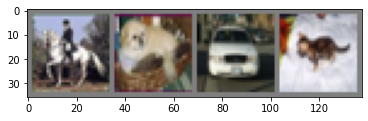

GroundTruth:  horse   dog   car   cat


In [19]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [20]:
model = vgg.VGG(conv, num_classes = 10, init_weights = True).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [21]:
outputs = model(images)

C:\Users\buddhalight\envs\buddhalight\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [22]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  horse   cat  ship  bird


The results seem pretty shit.

Let us look at how the network performs on the whole dataset.

In [27]:
correct = 0
total = 0

#Since we're not training, we don't neet to calculate the gradients for our outputs

with torch.no_grad():

    for X, Y in test_loader:

        X = X.to(device)
        Y = Y.to(device)

        #calculate outputs by running images through the network
        output = model(X)

        #the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(output, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()
        
print('Correct Label: {} out of Total Label: {}'.format(correct, total))

print('Accuracy of the network on the 10000 test images: {:.6f} %'.format(100 * correct / total))

Correct Label: 5394 out of Total Label: 10000
Accuracy of the network on the 10000 test images: 53.940000 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [31]:
#prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

print(correct_pred, total_pred)

#again no gradients needed
with torch.no_grad():
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        _, predictions = torch.max(output, 1)
        #collect the correct predictions for each class

        for label, prediction in zip(Y, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

#print accuracy for each class
for classname in classes:
    accuracy = 100 * correct_pred[classname] / total_pred[classname]
    print('Accuracy for class {} is {} %'.format(classname, accuracy))

{'plane': 0, 'car': 0, 'bird': 0, 'cat': 0, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0} {'plane': 0, 'car': 0, 'bird': 0, 'cat': 0, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0}
Accuracy for class plane is 57.4 %
Accuracy for class car is 67.6 %
Accuracy for class bird is 43.5 %
Accuracy for class cat is 39.3 %
Accuracy for class deer is 47.4 %
Accuracy for class dog is 44.8 %
Accuracy for class frog is 58.1 %
Accuracy for class horse is 58.2 %
Accuracy for class ship is 63.4 %
Accuracy for class truck is 61.6 %
